In [15]:
#Load Importance sampling functions
import sys
sys.path.append('../src')

In [16]:
import datetime, zarr, dask, rasterio as rio, rioxarray as rxr, pandas as pd, rasterstats, tqdm, pathlib, geopandas as gpd, matplotlib.pyplot as plt
from scipy.stats import uniform, norm, multivariate_normal, truncnorm
import plotnine as pn
import os
import subprocess
import importlib
import pyDOE2
from tqdm import tqdm

from transpose import *
from utils import *
from evaluation import *

<h5>Download Data</h5>

In [ ]:
#Download data from AWS
#1. In terminal - 
    # curl "https://awscli.amazonaws.com/awscli-exe-linux-x86_64.zip" -o "awscliv2.zip"
    # unzip awscliv2.zip
    # sudo ./aws/install
#3. In terminal inside docker type - aws configure
#4. Add key provided by admin and set region to us-west-2 and output format to json

#Duwamish S3 URL for tif files 
s3_url = "s3://importance-sampling-sst/Kanawha/"
local_dir = "/workspaces/Importance-Sampling-for-SST/data/0_source/Kanawha"
os.makedirs(local_dir)
subprocess.run(["aws","s3","cp",s3_url,local_dir,"--recursive"], check = True)

<h5> Load Data</h5>

In [17]:
#Locate data
path_sp_watershed = "/workspaces/Importance-Sampling-for-SST/data/0_source/Kanawha/geojson/kanawha-basin.geojson"
path_sp_domain = "/workspaces/Importance-Sampling-for-SST/data/0_source/Kanawha/geojson/kanawha-transpo-area-v01.geojson"

path_storm = pathlib.Path('/workspaces/Importance-Sampling-for-SST/data/0_source/Kanawha/catalog')
df_storms = pd.read_pickle(path_storm/'catalog.pkl')

In [18]:
#Load shapefiles and match projection with rasters
sp_watershed = gpd.read_file(path_sp_watershed)
sp_watershed = match_crs_to_raster(sp_watershed, df_storms['path'].iloc[0])

sp_domain = gpd.read_file(path_sp_domain)
sp_domain = match_crs_to_raster(sp_domain, df_storms['path'].iloc[0])

Reprojecting polygon from EPSG:4326 to EPSG:5070...
Reprojecting polygon from EPSG:4326 to EPSG:5070...


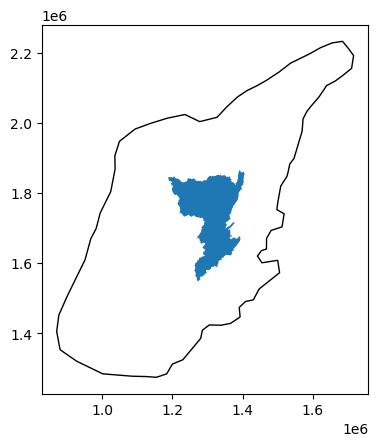

In [19]:
sp_watershed.plot()
sp_domain.plot(ax=plt.gca(),facecolor="none")
plt.show()

In [20]:
v_watershed_stats = get_sp_stats(sp_watershed)
v_domain_stats = get_sp_stats(sp_domain)
print(v_watershed_stats, v_domain_stats)

minx        1.187435e+06
miny        1.548200e+06
maxx        1.405844e+06
maxy        1.864701e+06
x           1.308113e+06
y           1.738216e+06
range_x     2.184095e+05
range_y     3.165013e+05
area_km2    5.084137e+04
Name: 0, dtype: float64 minx        8.700719e+05
miny        1.274827e+06
maxx        1.716061e+06
maxy        2.232237e+06
x           1.249180e+06
y           1.709628e+06
range_x     8.459895e+05
range_y     9.574099e+05
area_km2    6.211256e+05
Name: 0, dtype: float64


<h5> Sampling </h5>

In [21]:
dist_x = truncnorm(**truncnorm_params(v_watershed_stats.x, v_watershed_stats.range_x*1, v_domain_stats.minx, v_domain_stats.maxx))
dist_y = truncnorm(**truncnorm_params(v_watershed_stats.y, v_watershed_stats.range_y*1, v_domain_stats.miny, v_domain_stats.maxy))

In [24]:
n_sim_mc_0 = 100000
n_sim_is_1 = 10000
df_storm_sample_mc_0 = sample_storms(df_storms, v_domain_stats, dist_x=None, dist_y=None, num_simulations=n_sim_mc_0)
df_storm_sample_mc_1 = sample_storms(df_storms, v_domain_stats, dist_x=None, dist_y=None, num_simulations=n_sim_is_1)
df_storm_sample_is_1 = sample_storms(df_storms, v_domain_stats, dist_x, dist_y, num_simulations=n_sim_is_1)

100%|██████████| 10000/10000 [00:02<00:00, 3703.91it/s]


In [25]:
#Full Monte
df_depths_mc_0 = compute_depths(df_storm_sample_mc_0, sp_watershed)

#Store
os.makedirs("/workspaces/Importance-Sampling-for-SST/data/1_interim/Kanawha", exist_ok=True)
df_depths_mc_0.to_pickle("/workspaces/Importance-Sampling-for-SST/data/1_interim/Kanawha/df_depths_mc_0.pkl")
df_depths_mc_0 = pd.read_pickle("/workspaces/Importance-Sampling-for-SST/data/1_interim/Kanawha/df_depths_mc_0.pkl")

100%|██████████| 100000/100000 [54:42<00:00, 30.47it/s] 


In [26]:
#Small Sample
df_depths_mc_1 = compute_depths(df_storm_sample_mc_1, sp_watershed)
df_depths_is_1 = compute_depths(df_storm_sample_is_1, sp_watershed)

100%|██████████| 10000/10000 [04:57<00:00, 33.57it/s]


In [29]:
df_freq_curve_mc_0 = get_return_period_poisson(df_depths_mc_0.depth, df_depths_mc_0.prob, lambda_rate = 10)
df_freq_curve_mc_1 = get_return_period_poisson(df_depths_mc_1.depth, df_depths_mc_1.prob, lambda_rate = 10)
df_freq_curve_is_1 = get_return_period_poisson(df_depths_is_1.depth, df_depths_is_1.prob, lambda_rate= 10)

<h5> Evaluate </h5>

In [30]:
print_sim_stats(df_depths_mc_0)
print_sim_stats(df_depths_mc_1)
print_sim_stats(df_depths_is_1)

Intersected: 99715 out of 100000 (99.72%)
Total Weights: Total  1.00, Intersected: 1.00
Depth: 14.39 ± 0.06
Depth Estimate: 14.39 ± 0.06
Intersected: 9975 out of 10000 (99.75%)
Total Weights: Total  1.00, Intersected: 1.00
Depth: 14.34 ± 0.19
Depth Estimate: 14.34 ± 0.19
Intersected: 9985 out of 10000 (99.85%)
Total Weights: Total  1.00, Intersected: 1.00
Depth: 14.56 ± 0.19
Depth Estimate: 14.45 ± 0.23


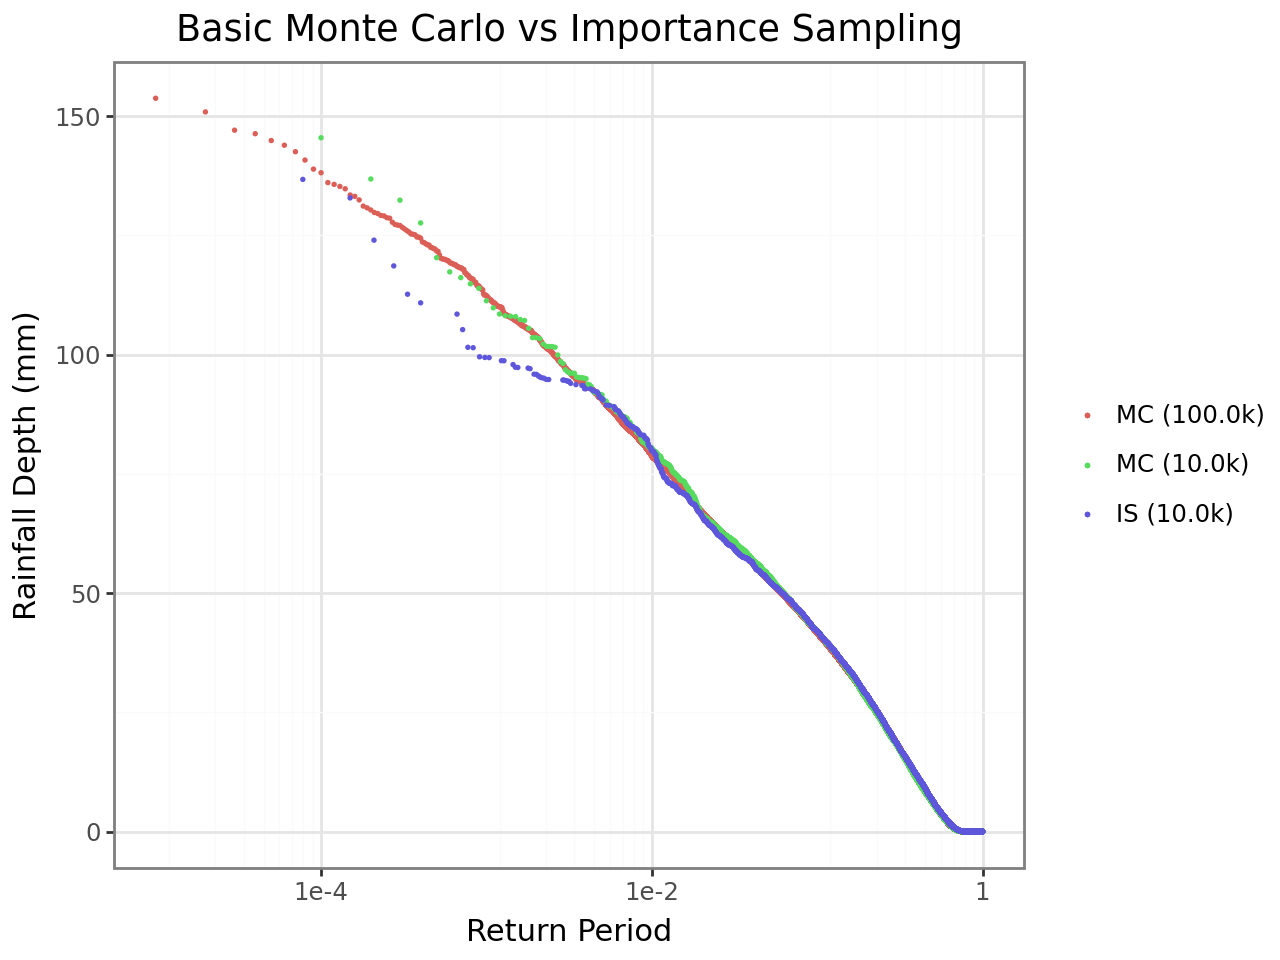

In [31]:
(pn.ggplot(mapping=pn.aes(x='prob_exceed', y='depth'))
        + pn.geom_point(data=df_freq_curve_mc_0, mapping=pn.aes(color=f'"MC ({n_sim_mc_0/1000}k)"'), size=0.1)
        + pn.geom_point(data=df_freq_curve_mc_1, mapping=pn.aes(color=f'"MC ({n_sim_is_1/1000}k)"'), size=0.1)
        + pn.geom_point(data=df_freq_curve_is_1, mapping=pn.aes(color=f'"IS ({n_sim_is_1/1000}k)"'), size=0.1)
        + pn.scale_x_log10()
        + pn.labs(
            x = 'Return Period',
            y = 'Rainfall Depth (mm)',
            title = 'Basic Monte Carlo vs Importance Sampling'
        )
        + pn.theme_bw()
        + pn.theme(
            title = pn.element_text(hjust = 0.5),
            # legend_position = 'bottom',
            legend_title = pn.element_blank(),
            legend_key = pn.element_blank(),
            axis_title_y = pn.element_text(ha = 'left'),
        )
    )

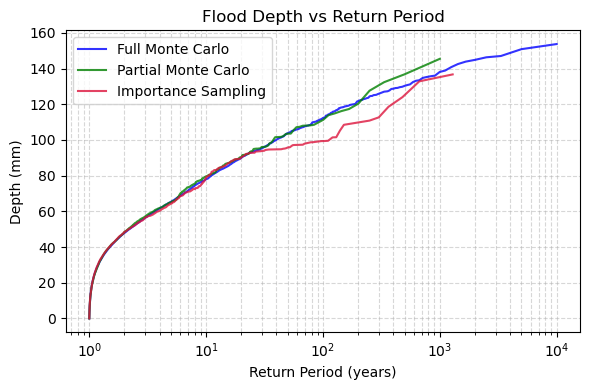

In [32]:
# Plot Return Period vs Depth with better colors
plt.figure(figsize=(6, 4))

plt.semilogx(df_freq_curve_mc_0['return_period'], df_freq_curve_mc_0['depth'],
             linestyle='-', color='blue', alpha=0.8, label='Full Monte Carlo')

plt.semilogx(df_freq_curve_mc_1['return_period'], df_freq_curve_mc_1['depth'],
             linestyle='-', color='green', alpha=0.8, label='Partial Monte Carlo')

plt.semilogx(df_freq_curve_is_1['return_period'], df_freq_curve_is_1['depth'],
             linestyle='-', color='crimson', alpha=0.8, label='Importance Sampling')

plt.xlabel('Return Period (years)')
plt.ylabel('Depth (mm)')
plt.title('Flood Depth vs Return Period')
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

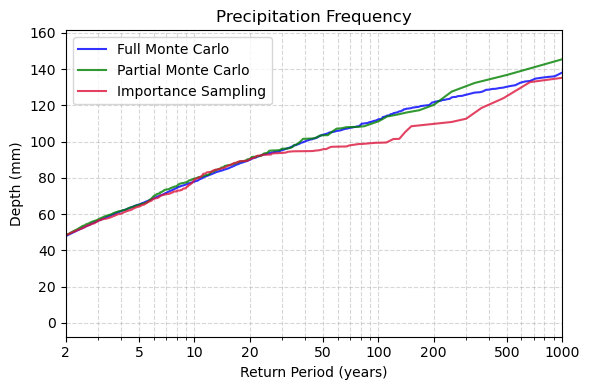

In [42]:
plt.figure(figsize=(6, 4))

plt.semilogx(df_freq_curve_mc_0['return_period'], df_freq_curve_mc_0['depth'],
             linestyle='-', color='blue', alpha=0.8, label='Full Monte Carlo')

plt.semilogx(df_freq_curve_mc_1['return_period'], df_freq_curve_mc_1['depth'],
             linestyle='-', color='green', alpha=0.8, label='Partial Monte Carlo')

plt.semilogx(df_freq_curve_is_1['return_period'], df_freq_curve_is_1['depth'],
             linestyle='-', color='crimson', alpha=0.8, label='Importance Sampling')

plt.xlabel('Return Period (years)')
plt.ylabel('Depth (mm)')
plt.title('Precipitation Frequency')

# Custom x-axis ticks on log scale
ticks = [2, 5, 10, 20, 50, 100, 200, 500, 1000]
plt.xlim(2, 1000)
plt.xticks(ticks, labels=[str(t) for t in ticks])

plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

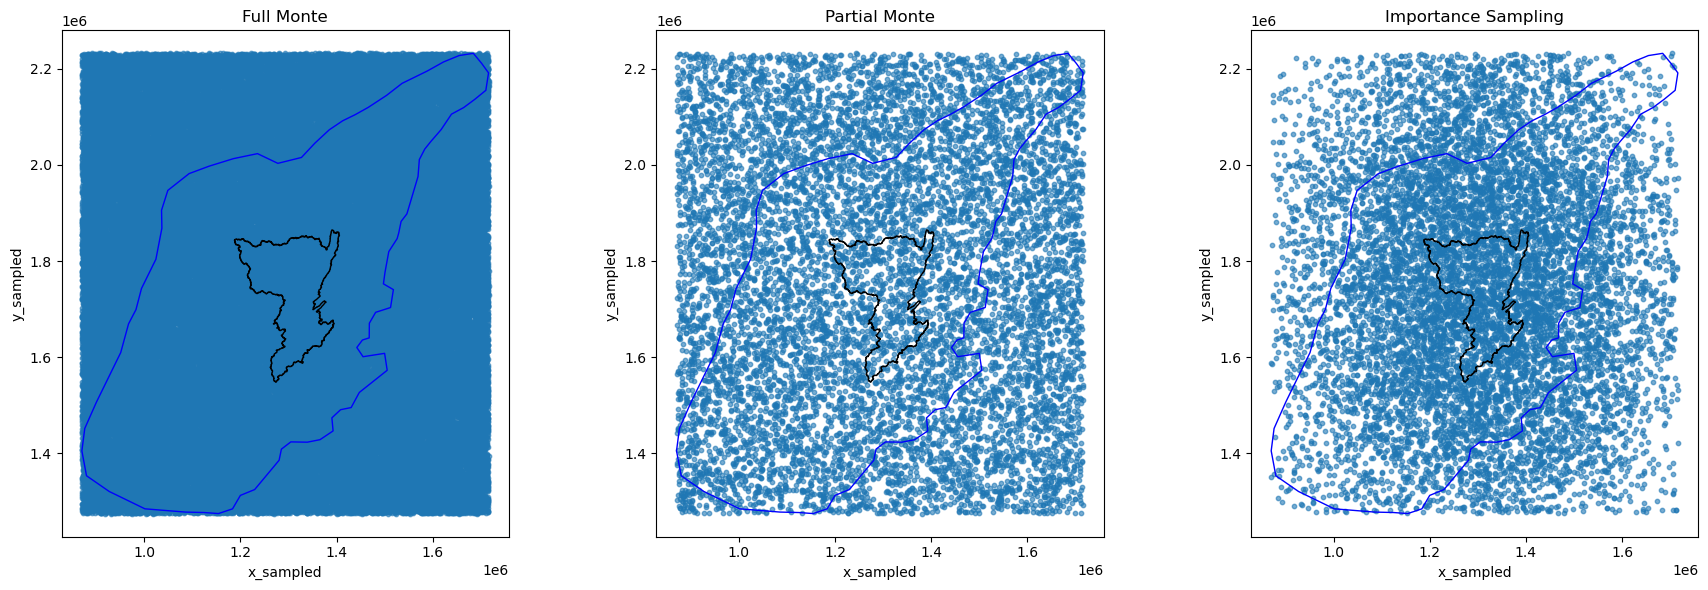

In [34]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
titles = ["Full Monte", "Partial Monte", "Importance Sampling"]
dfs = [df_depths_mc_0, df_depths_mc_1, df_depths_is_1]

for ax, df, title in zip(axes, dfs, titles):
    df.plot.scatter(x="x_sampled", y="y_sampled", s=10, alpha=0.6, ax=ax)
    sp_watershed.plot(ax=ax, edgecolor="black", facecolor="none", linewidth=1)
    sp_domain.plot(ax=ax, edgecolor="blue", facecolor="none", linewidth=1)
    ax.set_title(title)

plt.tight_layout()
plt.show()